# SAN DIEGO BIRD CLASSIFIER
Accounting for all bird species found in the greater San Diego County Area

## Dependencies & Imports

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import requests
from serpapi import GoogleSearch
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.applications import EfficientNetB0
from tensorflow import keras
from tkinter import filedialog

2025-04-14 17:45:28.778773: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-14 17:45:33.126121: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744677934.438880    3665 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744677934.735266    3665 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744677937.723666    3665 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Verify GPU is Available

In [ ]:
print("TensorFlow version:", tf.__version__)
print("GPUs available:", tf.config.list_physical_devices('GPU'))

from tensorflow.python.client import device_lib
print("\nLocal devices:")
for device in device_lib.list_local_devices():
    print(f"{device.name} - {device.device_type}")

## Read and Clean Data

In [2]:
df = pd.read_csv(r'/mnt/c/Users/ashha/OneDrive/Desktop/SAN DIEGO BIRD CLASSIFIER/SD Birds.csv')
df.head()

,Bird Names,Common Name
0,Phoebastria nigripes,"Albatross, Black-footed"
1,Phoebastria immutabilis,"Albatross, Laysan"
2,Phoebastria albatrus,"Albatross, Short-tailed"
3,Anhinga anhinga,Anhinga
4,Ptychoramphus aleuticus,"Auklet, Cassin's"


In [3]:
# Ensure there are no duplicates in the DataFrame
duplicates = df['Bird Names'].duplicated(keep=False)
if duplicates.any():
    duplicated_names = df[duplicates]['Bird Names'].unique()
    raise ValueError(f"Duplicate entries found for species: {duplicated_names}")

In [4]:
bird_list = df['Bird Names'].to_numpy()
bird_species = bird_list

In [5]:
def reformat_common_name(name):
    if ', ' in name:
        parts = name.split(', ', 1)  # Split at the first comma
        return f"{parts[1].strip()} {parts[0].strip()}"
    return name  # Return as-is if no comma


# Create a dictionary mapping (e.g., scientific to common name)
COMMON_NAMES = {}
COMMON_LIST = []
for species in bird_species:
  common_n = reformat_common_name(df[df['Bird Names']==species]['Common Name'].item())
  COMMON_NAMES[species] = common_n
  COMMON_LIST.append(common_n)

# Print the reformatted dictionary
print(COMMON_NAMES)

{'Phoebastria nigripes': 'Black-footed Albatross', 'Phoebastria immutabilis': 'Laysan Albatross', 'Phoebastria albatrus': 'Short-tailed Albatross', 'Anhinga anhinga': 'Anhinga', 'Ptychoramphus aleuticus': "Cassin's Auklet", 'Aethia psittacula': 'Parakeet Auklet', 'Cerorhinca monocerata': 'Rhinoceros Auklet', 'Recurvirostra americana': 'American Avocet', 'Euplectes franciscanus': 'Orange Bishop', 'Botaurus lentiginosus': 'American Bittern', 'Ixobrychus exilis': 'Least Bittern', 'Euphagus cyanocephalus': "Brewer's Blackbird", 'Agelaius phoeniceus': 'Red-winged Blackbird', 'Euphagus carolinus': 'Rusty Blackbird', 'Agelaius tricolor': 'Tricolored Blackbird', 'Xanthocephalus xanthocephalus': 'Yellow-headed Blackbird', 'Sialia currucoides': 'Mountain Bluebird', 'Sialia mexicana': 'Western Bluebird', 'Dolichonyx oryzivorus': 'Bobolink', 'Sula nebouxii': 'Blue-footed Booby', 'Sula leucogaster': 'Brown Booby', 'Sula dactylatra': 'Masked Booby', 'Sula granti': 'Nazca Booby', 'Sula sula': 'Red-fo

## Scrape Images

In [ ]:
#SerpAPI scraping with Google
main_folder = "/mnt/c/Users/ashha/OneDrive/Desktop/SAN DIEGO BIRD CLASSIFIER/sd_bird_images"
for species in bird_species:
    # Create a subfolder for each species
    species_folder = os.path.join(main_folder, species)
    os.makedirs(species_folder, exist_ok=True)
    page = 0
    success_count = 0

    while success_count < 300:
      params = {
        "q": f"{COMMON_NAMES[species]} bird -clipart -logo -watermark -drawing -animation",  
        "tbm": "isch",  
        "ijn": str(page),
        "api_key": 'a3e4f883cbe59ba0c05f274e77cde264dec881472cbb2aa6d1af408a3d509f76',
        "img_type": "photo",
        "img_color_type": "color"
      }

      search = GoogleSearch(params)
      results = search.get_dict()

      i = 0
      if 'images_results' in results:
        for image in results['images_results']:
          if success_count >= 300:
            break
          img_url = image['original']
          img_filename = f"{species}_CNB_{success_count}.jpg"
          img_path = os.path.join(species_folder, img_filename)
          try:
            response = requests.get(img_url, timeout=10)
            if response.status_code == 200 and 'image' in response.headers.get('content-type', ''):
                with open(img_path, 'wb') as f:
                  f.write(response.content)
                success_count+=1
          except requests.exceptions.Timeout:
                  print(f"Timeout occurred for {img_url}")
          except requests.exceptions.RequestException as e:
                  print(f"An error occurred: {e}")
        page+=1

In [ ]:
#SerpAPI scraping with Bing
for species in bird_species:
    # Create a subfolder for each species
    species_folder = os.path.join(main_folder, species)
    os.makedirs(species_folder, exist_ok=True)  
    page = 0
    success_count = 0

    while success_count < 300:
      params = {
        "q": f"{COMMON_NAMES[species]} bird -clipart -logo -watermark -drawing -animation",  
        "engine": "bing_images",  
        "api_key": 'a3e4f883cbe59ba0c05f274e77cde264dec881472cbb2aa6d1af408a3d509f76',
        "photo": "photo",
        "color2": "color"
      }

      search = GoogleSearch(params)
      results = search.get_dict()

      i = 0
      if 'images_results' in results:
        for image in results['images_results']:
          if success_count >= 300:
            break
          img_url = image['original']
          img_filename = f"{species}_CN_{success_count}.jpg"
          img_path = os.path.join(species_folder, img_filename)
          try:
            response = requests.get(img_url, timeout=10)
            if response.status_code == 200 and 'image' in response.headers.get('content-type', ''):
                with open(img_path, 'wb') as f:
                  f.write(response.content)
                success_count+=1
          except requests.exceptions.Timeout:
                  print(f"Timeout occurred for {img_url}")
          except requests.exceptions.RequestException as e:
                  print(f"An error occurred: {e}")
        page+=1

## Split, Train, Test

In [ ]:
#Spltting data
base_dir = "/mnt/c/Users/ashha/OneDrive/Desktop/SAN DIEGO BIRD CLASSIFIER/sd_bird_images"
train_dir = "/mnt/c/Users/ashha/OneDrive/Desktop/SAN DIEGO BIRD CLASSIFIER/sd_bird_images-train"
val_dir = "/mnt/c/Users/ashha/OneDrive/Desktop/SAN DIEGO BIRD CLASSIFIER/sd_bird_images-validation"

#Create folders
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

#Split data
for species in os.listdir(base_dir):
  species_path = os.path.join(base_dir, species)
  if os.path.isdir(species_path):
    images = os.listdir(species_path)
    if images:
      train_images, val_images = train_test_split(images, test_size =0.2, random_state=42)

      os.makedirs(os.path.join(train_dir,species),exist_ok=True)
      os.makedirs(os.path.join(val_dir,species),exist_ok=True)

      for img in train_images:
        shutil.move(os.path.join(species_path, img), os.path.join(train_dir, species, img))
      for img in val_images:
        shutil.move(os.path.join(species_path, img), os.path.join(val_dir, species, img))

### Verify images

In [ ]:
def convert_to_jpg(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    if img.format != 'JPEG': 
                        new_file_path = os.path.splitext(file_path)[0] + '.jpg'
                        img.convert('RGB').save(new_file_path, 'JPEG')
                        os.remove(file_path) 
            except Exception as e:
                print(f"Error converting file {file_path}: {e}")

convert_to_jpg(train_dir)
convert_to_jpg(val_dir)

In [ ]:
def strict_image_validator(dataset_dir):
    invalid_files = []
    for root, _, files in os.walk(dataset_dir):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = tf.io.read_file(file_path)
                decoded_img = tf.image.decode_image(img, channels=3)
                if decoded_img.shape[-1] != 3:
                    raise ValueError(f"Invalid channels: {file_path}")
            except Exception as e:
                print(f"🚨 TensorFlow failed to decode {file_path}: {str(e)}")
                invalid_files.append(file_path)

    for file_path in invalid_files:
        os.remove(file_path)
        print(f"Removed: {file_path}")

strict_image_validator(train_dir)
strict_image_validator(val_dir)

In [ ]:
#Verify scraped data looks good

# Load pre-trained ImageNet model (includes bird classes)
model = EfficientNetB0(weights='imagenet')

BIRD_LABELS = {
    # General bird terms
    'bird', 'birds', 'waterbird', 'songbird', 'fowl', 'waterfowl', 'raptor', 'seabird',
    'shorebird', 'wader', 'passerine', 'waterfowl', 'wildfowl', 'gamebird', 'perching',

    # Core species types from names
    'albatross', 'auklet', 'avocet', 'bishop', 'bittern', 'blackbird', 'bluebird',
    'bobolink', 'booby', 'brant', 'bufflehead', 'bunting', 'bushtit', 'canvasback',
    'caracara', 'cardinal', 'catbird', 'chat', 'chickadee', 'condor', 'coot', 'cormorant',
    'cowbird', 'crane', 'creeper', 'crossbill', 'crow', 'cuckoo', 'curlew', 'darter',
    'dickcissel', 'dove', 'dowitcher', 'duck', 'dunlin', 'eagle', 'egret', 'eider',
    'falcon', 'finch', 'flicker', 'flycatcher', 'frigatebird', 'fulmar', 'gadwall',
    'gallinule', 'gnatcatcher', 'godwit', 'goldeneye', 'goldfinch', 'goose', 'goshawk',
    'grackle', 'grebe', 'grosbeak', 'gull', 'harrier', 'hawk', 'heron', 'hummingbird',
    'ibis', 'jaeger', 'jay', 'junco', 'kestrel', 'killdeer', 'kingbird', 'kingfisher',
    'kinglet', 'kite', 'kittiwake', 'knot', 'lark', 'longspur', 'loon', 'macaw', 'mallard',
    'martin', 'meadowlark', 'merganser', 'merlin', 'mockingbird', 'murre', 'murrelet',
    'nighthawk', 'nutcracker', 'nuthatch', 'oriole', 'osprey', 'ovenbird', 'owl',
    'oystercatcher', 'parakeet', 'parrot', 'parula', 'pelican', 'petrel', 'pewee',
    'phalarope', 'pheasant', 'phoebe', 'pigeon', 'pintail', 'pipit', 'plover', 'poorwill',
    'puffin', 'pyrrhuloxia', 'quail', 'rail', 'raven', 'redhead', 'redstart', 'roadrunner',
    'robin', 'ruff', 'sanderling', 'sandpiper', 'sapsucker', 'scaup', 'scoter', 'shearwater',
    'shelduck', 'shoveler', 'shrike', 'siskin', 'skimmer', 'skua', 'snipe', 'solitaire',
    'sora', 'sparrow', 'spoonbill', 'starling', 'stilt', 'stint', 'stork', 'stormpetrel',
    'surfbird', 'swallow', 'swan', 'swift', 'tanager', 'tattler', 'teal', 'tern', 'thrasher',
    'thrush', 'titmouse', 'towhee', 'tropicbird', 'turkey', 'turnstone', 'verdin', 'vireo',
    'vulture', 'warbler', 'waterthrush', 'waxwing', 'wheatear', 'whimbrel', 'whipoorwill',
    'wigeon', 'willet', 'woodpecker', 'wren', 'wrentit', 'yellowlegs', 'yellowthroat',

    # Special cases from specific names
    'whistling', 'collared', 'hooded', 'masked', 'ringed', 'tailed', 'footed', 'crested',
    'winged', 'crowned', 'throated', 'breasted', 'bellied', 'rumped', 'backed', 'capped',
    'billed', 'shouldered', 'tricolored', 'pygmy', 'roughwinged', 'wood', 'storm', 'petrel'
}

def is_bird(img_path, threshold=0.1):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img) / 255.0
    x = np.expand_dims(x, axis=0)

    # Get predictions from the model
    preds = model.predict(x)

    # Decode the top 3 predictions
    decoded = tf.keras.applications.imagenet_utils.decode_predictions(preds, top=3)[0]
    pred_labels = [label.lower() for (_, label, _) in decoded]

    # Check if any decoded label is in the bird labels set
    return any(label in BIRD_LABELS for label in pred_labels)

21834768/21834768 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
def filter_non_birds(species_folder):
    for img_file in os.listdir(species_folder):
        img_path = os.path.join(species_folder, img_file)
        try:
            if not is_bird(img_path):
                os.remove(img_path)
        except Exception as e:
            print(f"Failed to process {img_path}: {e}")
            os.remove(img_path)  

for species in bird_species:
    species_folder_train = os.path.join(train_dir, species)
    species_folder_val = os.path.join(val_dir, species)
    filter_non_birds(species_folder_train)
    filter_non_birds(species_folder_val)

### Get Datasets

In [6]:
train_data = tf.keras.utils.image_dataset_from_directory(
    '/mnt/c/Users/ashha/OneDrive/Desktop/SAN DIEGO BIRD CLASSIFIER/sd_bird_images-train',
    image_size = (256,256),
    batch_size=64
)

val_data = tf.keras.utils.image_dataset_from_directory(
    '/mnt/c/Users/ashha/OneDrive/Desktop/SAN DIEGO BIRD CLASSIFIER/sd_bird_images-validation',
    image_size = (256,256),
    batch_size=64
)
class_names = train_data.class_names

def preprocess(image, label):
    return image, label

train_data = train_data.map(preprocess)
val_data = val_data.map(preprocess)

Found 232389 files belonging to 530 classes.


I0000 00:00:1744678084.344818    3665 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9706 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 58331 files belonging to 530 classes.


In [ ]:
class_names = sorted([
    d for d in os.listdir(train_dir)
    if os.path.isdir(os.path.join(train_dir, d))
])
n_classes = len(class_names)

if n_classes == 0:
    print("No classes found in the training directory.")
    class_weights = {}
else:
    class_counts = []
    for class_name in class_names:
        class_dir = os.path.join(train_dir, class_name)
        count = len([
            f for f in os.listdir(class_dir)
            if f.lower().endswith('.jpg') and os.path.isfile(os.path.join(class_dir, f))
        ])
        class_counts.append(count)

    total_samples = sum(class_counts)

    class_weights = {
        i: total_samples / (n_classes * count) if count > 0 else 0
        for i, count in enumerate(class_counts)
    }

    print(f"Found {n_classes} classes with weights:")
    for i, (cls, weight) in enumerate(class_weights.items()):
        if i < 5: 
            print(f"{class_names[cls]}: {weight:.2f} (n={class_counts[cls]})")

Found 530 classes with weights:
Accipiter cooperii: 0.99 (n=445)
Accipiter gentilis: 1.01 (n=433)
Accipiter striatus: 0.96 (n=457)
Actitis macularia: 0.99 (n=444)
Aechmophorus clarkii: 0.98 (n=447)


In [7]:
# Enable mixed precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [ ]:
# Define custom callback to save the model every 5 epochs
class SaveEvery5Epochs(tf.keras.callbacks.Callback):
    def __init__(self, save_path):
        super(SaveEvery5Epochs, self).__init__()
        self.save_path = save_path
        os.makedirs(save_path, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 5 == 0:
            full_path = os.path.join(self.save_path, f'bird_classifier_epoch_{epoch+1}.keras')
            self.model.save(full_path)
            print(f"Model saved to: {full_path}")

save_path = "/mnt/c/Users/ashha/OneDrive/Desktop/SAN DIEGO BIRD CLASSIFIER/models"

### Training CNN Using Transfer Learning

In [ ]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.RandomContrast(0.4),
    # Advanced augmentations:
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

# Base model (EfficientNetB0 for 128x128 inputs)
base_model = tf.keras.applications.EfficientNetV2L(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet',
)

# Freeze first 80% of layers
base_model.trainable = True
for layer in base_model.layers[:int(len(base_model.layers)*0.8)]:
    layer.trainable = False

# Model architecture
model = tf.keras.Sequential([
    tf.keras.Input(shape=(256, 256, 3)),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),  
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1024, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.005)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.005)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(530, activation='softmax')
])

# Optimizer (non-legacy)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Compile
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir='./logs', profile_batch=0),
    SaveEvery5Epochs(save_path)  
]

# Train
history = model.fit(
    train_data,
    epochs=10,
    validation_data=val_data,
    class_weight=class_weights,
    callbacks=callbacks
)

In [ ]:
# Save model
os.makedirs(save_path, exist_ok=True)
full_path = os.path.join(save_path, 'bird_classifier.keras')
model.save(full_path)
print(f"Model saved to: {full_path}")

Model saved to: /mnt/c/Users/ashha/OneDrive/Desktop/SAN DIEGO BIRD CLASSIFIER/models/bird_classifier.keras


In [8]:
model = keras.models.load_model('/mnt/c/Users/ashha/OneDrive/Desktop/SAN DIEGO BIRD CLASSIFIER/models/bird_classifier.keras')

In [10]:
loss, top1_acc = model.evaluate(val_data, verbose=1)
print(f"Top-1 Accuracy: {top1_acc:.4f}")

2025-04-14 16:14:30.679541: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
I0000 00:00:1744672476.621978  128876 cuda_dnn.cc:529] Loaded cuDNN version 90300


 11/912 ━━━━━━━━━━━━━━━━━━━━ 9:25 628ms/step - accuracy: 0.7644 - loss: 1.3691

2025-04-14 16:15:15.703956: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: extra compressed data


 72/912 ━━━━━━━━━━━━━━━━━━━━ 8:21 597ms/step - accuracy: 0.7649 - loss: 1.3346

2025-04-14 16:15:51.829810: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: eXIf: duplicate


306/912 ━━━━━━━━━━━━━━━━━━━━ 6:03 599ms/step - accuracy: 0.7695 - loss: 1.2945

2025-04-14 16:18:12.165902: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


575/912 ━━━━━━━━━━━━━━━━━━━━ 3:20 596ms/step - accuracy: 0.7710 - loss: 1.2821

2025-04-14 16:20:51.572603: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


629/912 ━━━━━━━━━━━━━━━━━━━━ 2:48 596ms/step - accuracy: 0.7712 - loss: 1.2812

2025-04-14 16:21:23.568777: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


639/912 ━━━━━━━━━━━━━━━━━━━━ 2:42 596ms/step - accuracy: 0.7712 - loss: 1.2812

2025-04-14 16:21:29.456350: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: eXIf: duplicate


649/912 ━━━━━━━━━━━━━━━━━━━━ 2:36 596ms/step - accuracy: 0.7712 - loss: 1.2811

2025-04-14 16:21:35.422184: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


703/912 ━━━━━━━━━━━━━━━━━━━━ 2:04 596ms/step - accuracy: 0.7712 - loss: 1.2808

2025-04-14 16:22:08.148879: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: eXIf: duplicate


751/912 ━━━━━━━━━━━━━━━━━━━━ 1:36 596ms/step - accuracy: 0.7713 - loss: 1.2804

2025-04-14 16:22:36.657025: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: eXIf: duplicate


781/912 ━━━━━━━━━━━━━━━━━━━━ 1:18 596ms/step - accuracy: 0.7713 - loss: 1.2803

2025-04-14 16:22:54.560786: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: eXIf: duplicate


783/912 ━━━━━━━━━━━━━━━━━━━━ 1:16 596ms/step - accuracy: 0.7713 - loss: 1.2803

2025-04-14 16:22:55.771084: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


912/912 ━━━━━━━━━━━━━━━━━━━━ 599s 598ms/step - accuracy: 0.7713 - loss: 1.2798
Top-1 Accuracy: 0.7716


In [ ]:
def sparse_top5_accuracy(y_true, y_pred):
    return tf.keras.metrics.sparse_top_k_categorical_accuracy(
        y_true, tf.cast(y_pred, tf.float32), k=5
    )

# Recompile the model with the custom metric
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy',
        sparse_top5_accuracy  
    ]
)

# Evaluate again
results = model.evaluate(val_data)
top5_acc = results[2]
print(f"Top-5 Accuracy: {top5_acc:.4f}")

 57/912 ━━━━━━━━━━━━━━━━━━━━ 8:21 587ms/step - accuracy: 0.7603 - loss: 1.3081 - sparse_top5_accuracy: 0.9188

2025-04-14 18:03:20.328331: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


118/912 ━━━━━━━━━━━━━━━━━━━━ 7:46 587ms/step - accuracy: 0.7652 - loss: 1.3046 - sparse_top5_accuracy: 0.9165

2025-04-14 18:03:56.123905: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


191/912 ━━━━━━━━━━━━━━━━━━━━ 7:03 587ms/step - accuracy: 0.7668 - loss: 1.3022 - sparse_top5_accuracy: 0.9159

2025-04-14 18:04:39.111836: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: extra compressed data


247/912 ━━━━━━━━━━━━━━━━━━━━ 6:31 588ms/step - accuracy: 0.7672 - loss: 1.3038 - sparse_top5_accuracy: 0.9153

2025-04-14 18:05:12.196747: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


270/912 ━━━━━━━━━━━━━━━━━━━━ 6:18 590ms/step - accuracy: 0.7673 - loss: 1.3036 - sparse_top5_accuracy: 0.9151

2025-04-14 18:05:26.176322: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: eXIf: duplicate


378/912 ━━━━━━━━━━━━━━━━━━━━ 5:18 597ms/step - accuracy: 0.7677 - loss: 1.3026 - sparse_top5_accuracy: 0.9149

2025-04-14 18:06:32.416664: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: eXIf: duplicate


419/912 ━━━━━━━━━━━━━━━━━━━━ 4:55 599ms/step - accuracy: 0.7678 - loss: 1.3021 - sparse_top5_accuracy: 0.9148

2025-04-14 18:06:57.708458: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: eXIf: duplicate


442/912 ━━━━━━━━━━━━━━━━━━━━ 4:41 599ms/step - accuracy: 0.7678 - loss: 1.3018 - sparse_top5_accuracy: 0.9148

2025-04-14 18:07:11.906872: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


642/912 ━━━━━━━━━━━━━━━━━━━━ 2:43 605ms/step - accuracy: 0.7686 - loss: 1.2976 - sparse_top5_accuracy: 0.9151

2025-04-14 18:09:14.987126: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: eXIf: duplicate


654/912 ━━━━━━━━━━━━━━━━━━━━ 2:36 605ms/step - accuracy: 0.7687 - loss: 1.2973 - sparse_top5_accuracy: 0.9151

2025-04-14 18:09:22.481584: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: eXIf: duplicate


870/912 ━━━━━━━━━━━━━━━━━━━━ 25s 608ms/step - accuracy: 0.7694 - loss: 1.2929 - sparse_top5_accuracy: 0.9155

2025-04-14 18:11:35.646843: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


912/912 ━━━━━━━━━━━━━━━━━━━━ 566s 608ms/step - accuracy: 0.7695 - loss: 1.2920 - sparse_top5_accuracy: 0.9156
Top-5 Accuracy: 0.9166


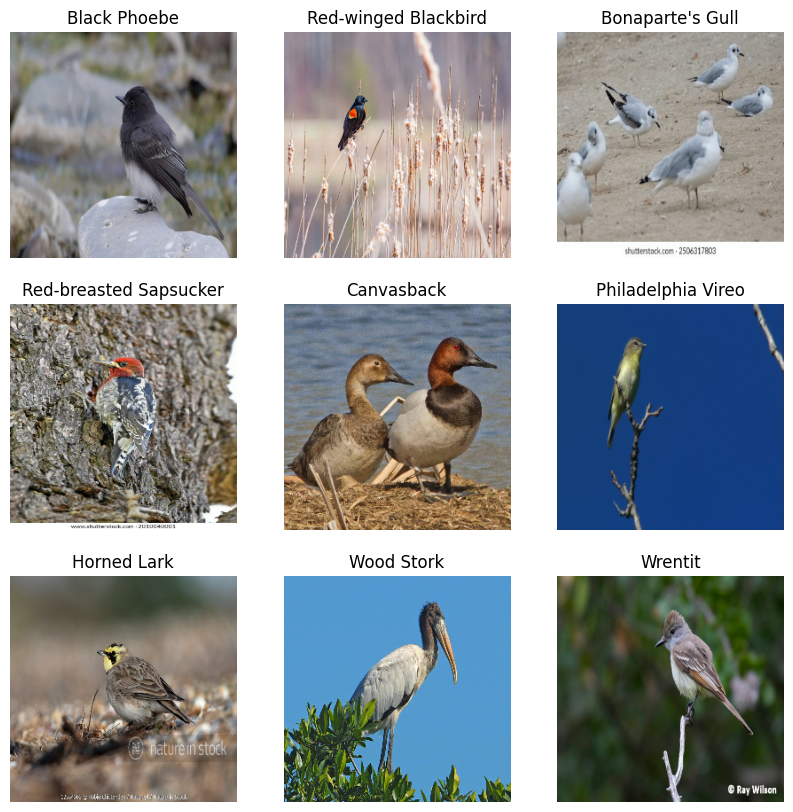

2025-04-14 16:35:37.248616: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
for images, labels in train_data.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Remove normalization
        species = class_names[labels[i].numpy()]
        plt.title(COMMON_NAMES.get(species, species))
        plt.axis("off")
    plt.show()

In [ ]:
def preprocess_image(image_path, img_size=(256, 256)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(img_size)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0)

In [14]:
import tkinter as tk
# --- User selects image ---
def predict_bird():
    root = tk.Tk()
    root.withdraw()
    image_path = filedialog.askopenfilename(
        title="Select an image",
        filetypes=[("Image files", "*.jpg *.jpeg *.png *.bmp *.gif")]
    )

    if not image_path:
        print("No image selected. Exiting.")
        exit()

    # --- Load image ---
    original_img = Image.open(image_path)

    # --- Show image ---
    plt.imshow(original_img)
    plt.axis('off')
    plt.show()

    # --- Predict ---
    processed_img = preprocess_image(image_path) 
    predictions = model.predict(processed_img)

    # --- Print top 5 predictions ---
    print("\nTop 5 Predictions:")
    sorted_indices = np.argsort(predictions[0])[::-1][:5]
    for i in sorted_indices:
        class_name = class_names[i]
        common_name = COMMON_NAMES.get(class_name, class_name)
        confidence = 100 * predictions[0][i]
        print(f"{common_name}: {confidence:.2f}%")

In [ ]:
predict_bird()

In [ ]:
def generate_readme_visualizations():
    # 1. Model Performance
    results = model.evaluate(val_data, verbose=1)
    plt.figure(figsize=(8, 5))
    plt.bar(['Top-1 Accuracy', 'Top-5 Accuracy'], 
            [results[1], results[2]], 
            color=['#2ecc71', '#3498db'])
    plt.title('Model Performance')
    plt.ylim(0, 1)
    for i, v in enumerate([results[1], results[2]]):
        plt.text(i, v + 0.01, f'{v:.2%}', ha='center')
    plt.savefig('model_performance.png')
    plt.close()
    
    # 2. Sample Predictions
    for images, labels in val_data.take(1):
        predictions = model.predict(images)
        plt.figure(figsize=(12, 8))
        for i in range(6):
            plt.subplot(2, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            true_class = class_names[labels[i]]
            pred_class = class_names[np.argmax(predictions[i])]
            color = 'green' if true_class == pred_class else 'red'
            plt.title(f'True: {COMMON_NAMES[true_class]}\nPred: {COMMON_NAMES[pred_class]}',
                     color=color, fontsize=10)
            plt.axis('off')
        plt.tight_layout()
        plt.savefig('sample_predictions.png')
        plt.close()
        break
    
    # 3. Class Distribution
    print("\nAnalyzing class distribution...")
    all_predictions = []
    all_labels = []
    
    for images, labels in val_data:
        batch_predictions = model.predict(images)
        all_predictions.extend(np.argmax(batch_predictions, axis=1))
        all_labels.extend(labels.numpy())
    
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    
    # Calculate per-class accuracy
    class_accuracies = {}
    for i, class_name in enumerate(class_names):
        mask = all_labels == i
        if np.sum(mask) > 0:
            accuracy = np.mean(all_predictions[mask] == all_labels[mask])
            class_accuracies[COMMON_NAMES[class_name]] = accuracy
    
    # Plot top and bottom 10 classes
    plt.figure(figsize=(15, 10))
    sorted_accuracies = dict(sorted(class_accuracies.items(), key=lambda x: x[1]))
    bottom_10 = dict(list(sorted_accuracies.items())[:10])
    top_10 = dict(list(sorted_accuracies.items())[-10:])
    
    plt.subplot(2, 1, 1)
    plt.bar(top_10.keys(), top_10.values(), color='#2ecc71')
    plt.title('Top 10 Most Accurately Predicted Species')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Accuracy')
    
    plt.subplot(2, 1, 2)
    plt.bar(bottom_10.keys(), bottom_10.values(), color='#e74c3c')
    plt.title('Bottom 10 Least Accurately Predicted Species')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Accuracy')
    
    plt.tight_layout()
    plt.savefig('class_distribution.png')
    plt.close()

# Generate the visualizations
generate_readme_visualizations()
print("Generated visualization files for README:")
print("1. model_performance.png - Shows the model's top-1 and top-5 accuracy")
print("2. sample_predictions.png - Displays sample predictions on validation data")
print("3. class_distribution.png - Shows the best and worst performing classes")